In [1]:
import sys
import copy
import torch
import numpy as np
import scipy as sp
import pandas as pd
import dill as pickle
import tensorflow as tf
import matplotlib.pyplot as plt
# mpl_style = "/home/zanardi/Workspace/Research/styles/matplotlib/paper_1column.mplstyle",
# plt.style.use(mpl_style)

In [2]:
sys.path.append("/home/zanardi/Codes/ML/ROMAr/romar/")
from romar import env
from romar import const
from romar import utils
from romar import backend as bkd
from romar.systems import BoxAd
from romar.roms import PCA
from romar import backend as bkd

import romar.postproc.plotting as pltt

In [3]:
env_opts = {
  "backend": "numpy",
  "device": "cpu",
  "device_idx": 0,
  "nb_threads": 2,
  "epsilon": None,
  "floatx": "float64"
}
env.set(**env_opts)

In [ ]:
path_to_dtb = "/home/zanardi/Codes/ML/ROMAr/romar/examples/database"
path_to_basis = "/home/zanardi/Codes/ML/ROMAr/run_old2/rad_on_test10/max_mom_2a/cobras_basis.p"
# path_to_basis = "/home/zanardi/Codes/ML/ROMAr/run/test1/max_mom_2_Tfull/cobras_basis.p"
path_to_mask = "/home/zanardi/Codes/ML/ROMAr/run/rad_on_test1/max_mom_2/rom_mask.txt"
path_to_data = "/home/zanardi/Codes/ML/ROMAr/run/rad_on_test1/data/"
cases = ["lrho_lT", "lrho_hT", "hrho_lT", "hrho_hT", "mrho_mT"]

In [43]:
system = BoxAd(
  species={k: path_to_dtb + "/species/" + k + ".json" for k in ("Ar", "Arp", "em")},
  kin_dtb=path_to_dtb + "/rates/kin_fit.p",
  rad_dtb=path_to_dtb + "/rates/rad_fit.p",
  use_rad=True,
  use_proj=False,
  use_tables=False
)

In [44]:
# basis1 = pickle.load(open(path_to_basis1, "rb"))
# basis1["xref"], basis1["xscale"]

In [45]:
basis = pickle.load(open(path_to_basis, "rb"))

In [46]:
# for k in ("xref", "xscale"):
#   err = np.abs((basis1[k] - basis[k]) / basis1[k])
#   print(err.max())
# for k in ("phi", "psi"):
#   err = np.abs((basis1[k][34] - basis[k][34]) / basis1[k][34])
#   print(err.max())

In [47]:
# for i in range(10):
#   nb = str(i+1)
#   b = basis["phi"][30][:,i]
#   pltt.plot_dist_2d(
#     x=np.arange(len(b)),
#     y=b,
#     labels=[r"$\epsilon_i$ [eV]", r"$\%s_{%s}$" % ("phi", nb)],
#     scales=["linear", "linear"],
#     markersize=1,
#     # figname=path + f"/{name}_{nb.zfill(2)}",
#     save=False,
#     show=True
#   )

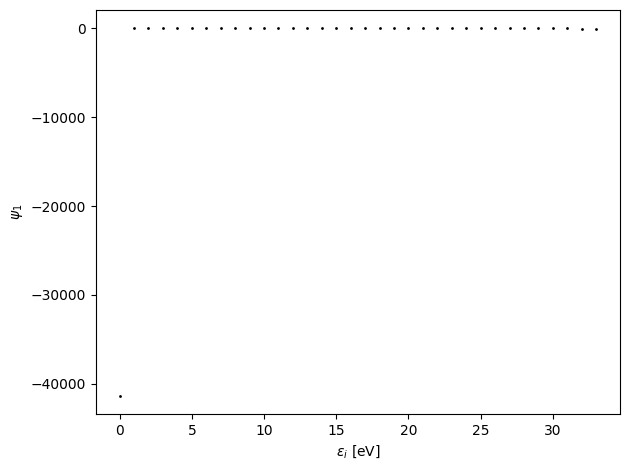

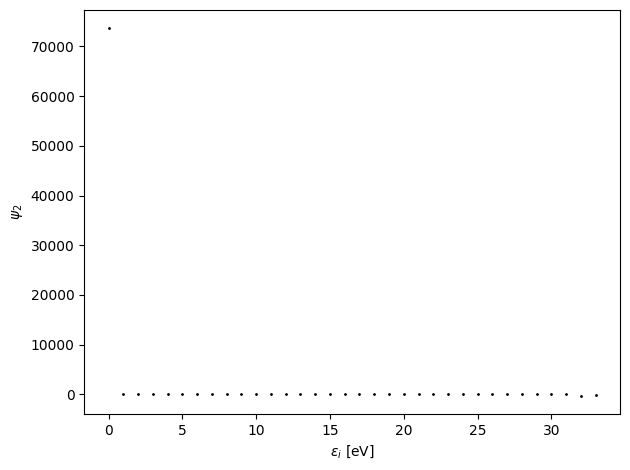

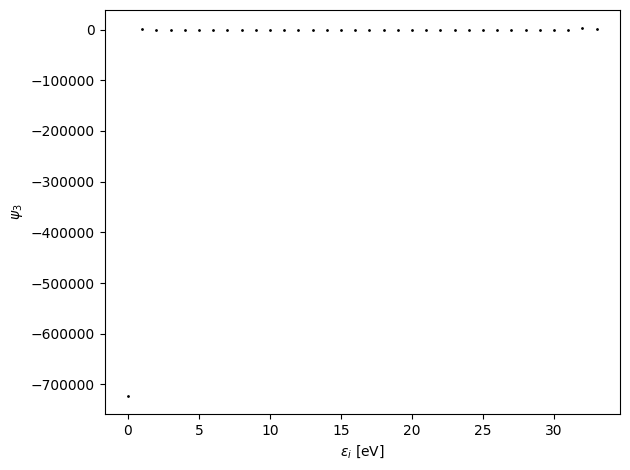

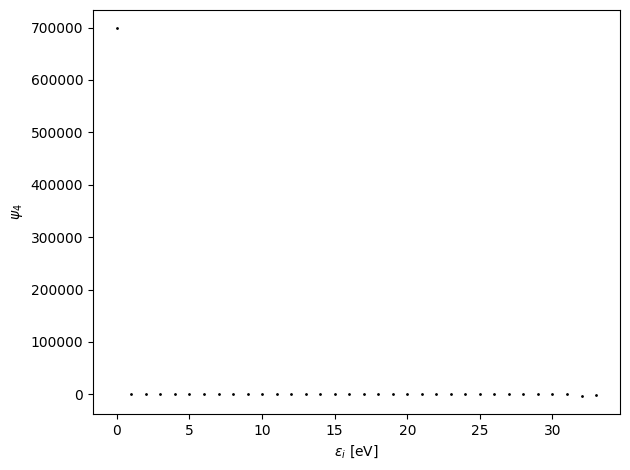

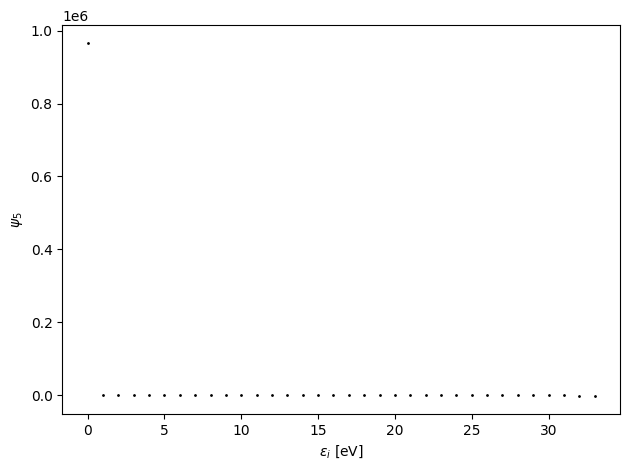

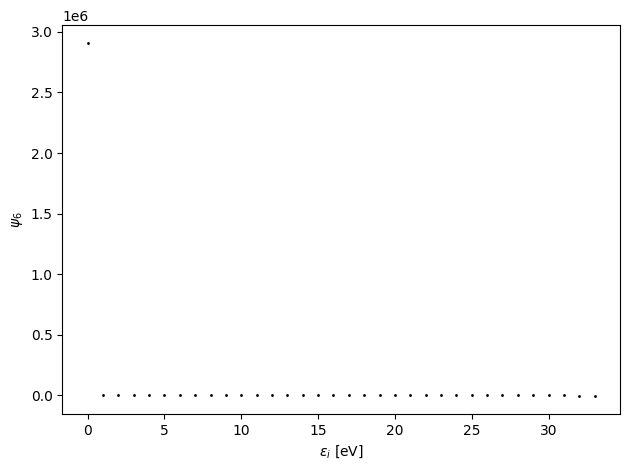

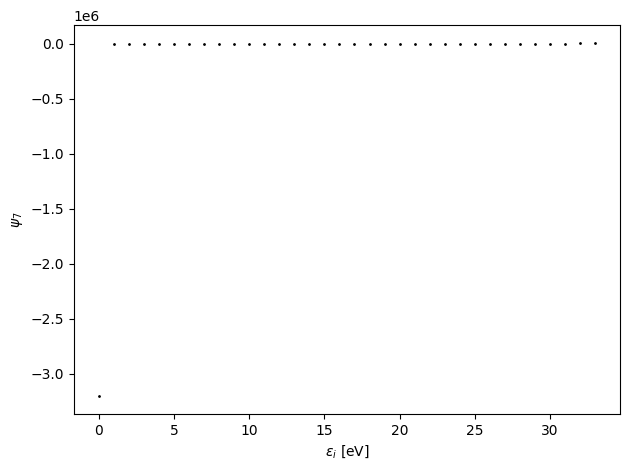

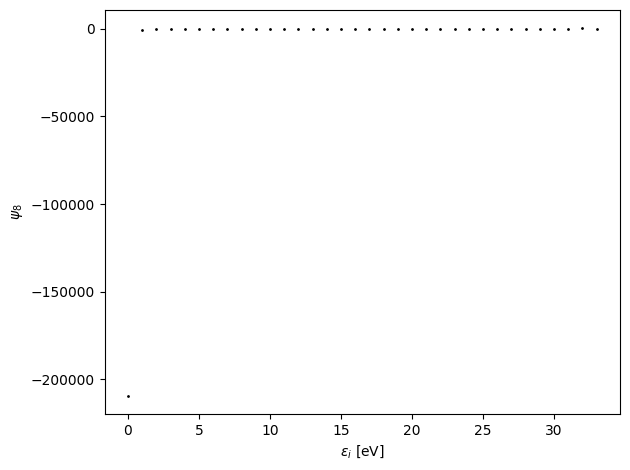

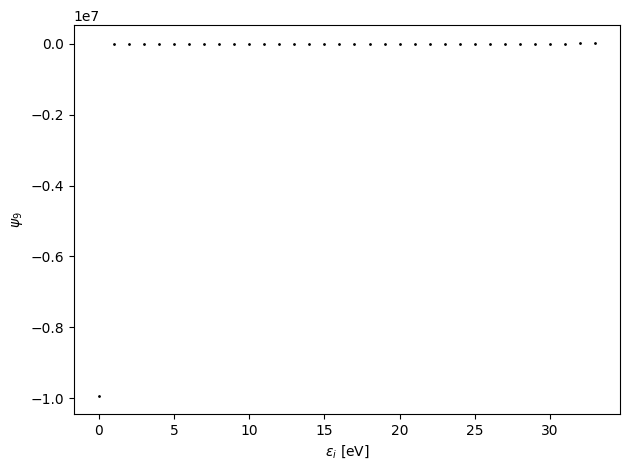

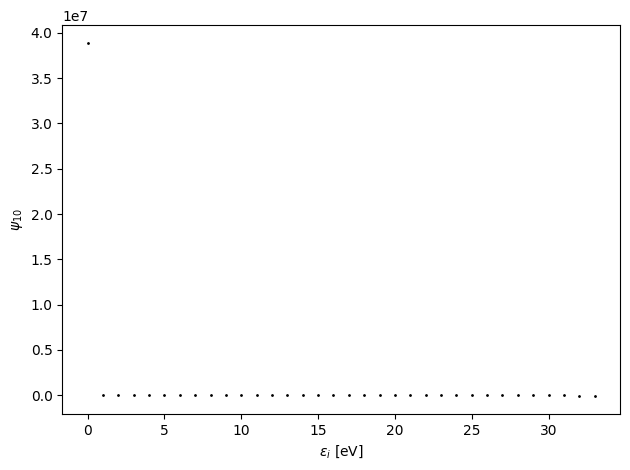

In [48]:
for i in range(10):
  nb = str(i+1)
  b = basis["psi"][30][:,i]
  pltt.plot_dist_2d(
    x=np.arange(len(b)),
    y=b,
    labels=[r"$\epsilon_i$ [eV]", r"$\%s_{%s}$" % ("psi", nb)],
    scales=["linear", "linear"],
    markersize=1,
    # figname=path + f"/{name}_{nb.zfill(2)}",
    save=False,
    show=True
  )

In [49]:
stop

NameError: name 'stop' is not defined

Load test cases

In [ ]:
testcases = {k: utils.load_case(filename=path_to_data + "case_" + k + ".p") for k in cases}

In [ ]:
for k, testcase in testcases.items():
  # Testcase
  print(k)
  print("="*20)
  t, y, rho = [testcase[k] for k in ("t", "y", "rho")]
  system.mix.set_rho(rho)
  n, Th, Te = system.get_prim(y)
  # Species
  for s in system.mix.species.values():
    print(s.name)
    for i in s.indices:
      plt.loglog(t, n[i])
    plt.show()
    plt.close()
  # Temperatures
  print("Th-Te")
  plt.semilogx(t, Th)
  plt.semilogx(t, Te)
  plt.show()
  plt.close()

Test ROM

In [ ]:
rdim = 8

system.rom.set(
  phi=basis["phi"][:,:rdim],
  psi=basis["psi"][:,:rdim],
  **{k: basis[k] for k in ("mask",)}# "xref", "xscale")}
)

In [ ]:
labels = {
  "Th": "$T_h$",
  "Te": "$T_e$",
  "Ar": "\\text{Ar}",
  "Arp": "\\text{Ar$^+$}",
  "em": "\\text{e$^-$}"
}

In [ ]:
isol, _ = system.compute_sol_rom(
  filename=path_to_data + "case_" + cases[-1] + ".p"
)

In [ ]:
tf.nest.map_structure(np.shape, isol)

In [ ]:
t = isol.pop("t")
err = {"CoBRAS": isol.pop("err")}
err["POD"] = err["CoBRAS"]
sol = isol
sol["CoBRAS"] = sol.pop("ROM")
sol["POD"] = sol["CoBRAS"]

In [ ]:
tf.nest.map_structure(np.shape, sol)

In [ ]:
tf.nest.map_structure(np.shape, err)

In [ ]:
pltt.plot_temp_evolution(
  path="./figs/",
  t=t,
  y=sol,
  err=err,
  tlim=None,
  ylim_err=None,
  err_scale="log",
  hline=1.0
)

In [ ]:
pltt.plot_mom_evolution(
  path="./figs/",
  t=t,
  y=sol,
  err=err,
  species=system.mix.species_order,
  labels=labels,
  tlim=None,
  ylim_err=None,
  err_scale="log",
  hline=1.0,
  max_mom=2
)

In [ ]:
for k, testcase in testcases.items():
  # Testcase
  print(k)
  print("="*20)
  # FOM solution
  t, y0, y, rho = [testcase[k] for k in ("t", "y0", "y", "rho")]
  system.mix.set_rho(rho)
  prim_fom = system.get_prim(y)
  mom_fom = system.compute_mom(prim_fom[0])
  # ROM solution
  yrom, _ = system.solve_rom(t, y0, rho)
  prim_rom = system.get_prim(yrom)
  mom_rom = system.compute_mom(prim_rom[0])
  nt = len(yrom.T)
  nt
  # Temperatures
  print("Th-Te")
  for i in range(2):
    plt.semilogx(t[:nt], prim_fom[1+i][:nt])
    plt.semilogx(t[:nt], prim_rom[1+i][:nt], ls="--", color=plt.gca().lines[-1].get_color(), lw=2.0)
  plt.show()
  plt.close()
  # Species
  for s in system.mix.species.values():
    print(s.name)
    for i in s.indices:
      plt.loglog(t[:nt], prim_fom[0][i,:nt])
      plt.loglog(t[:nt], prim_rom[0][i,:nt], ls="--", color=plt.gca().lines[-1].get_color(), lw=2.0)
    plt.show()
    plt.close()
  # Moments
  for s in system.mix.species.values():
    if s.name != "em":
      for m in range(2):
        print(s.name+f" - Moment: {m}")
        plt.semilogx(t[:nt], mom_fom[s.name][f"m{m}"][:nt])
        plt.semilogx(t[:nt], mom_rom[s.name][f"m{m}"][:nt], ls="--", color=plt.gca().lines[-1].get_color(), lw=2.0)
        plt.yscale("log" if m == 0 else "linear")
        plt.show()
        plt.close()